This time, we will use open, high, low, close. 

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical   

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
train_x_2.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [5]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [8]:
OHLC = full_df[:,:,[1,2,3,4]] 
OHLC.shape

(7661, 1500, 4)

In [9]:
volume = full_df[:,:,5]
volume.shape

(7661, 1500)

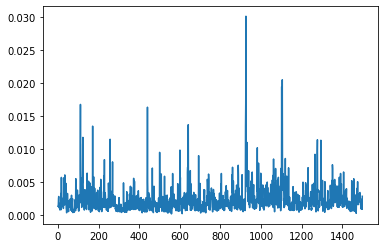

In [30]:
# if we look at the plot of volume, it does not seem to fluctuate as much compared to the price.  
plt.plot(volume[0])

# Preprocess Data

In [10]:
K = 120 
N = 30
seq_len = 1500 
features = 4 # open, high, low, close 
X = [] 
Y = [] 
X_volume = [] 

for j in tqdm(range(OHLC.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X_volume.append(volume[j, i:i+N])
        X.append(OHLC[j, i:i+N, :]) 
        Y.append(OHLC[j, i+N+K, 0]) # get open prices as target
        i += 1   
        

X = np.asarray(X) 
Y = np.asarray(Y)
X_volume = np.asarray(X_volume)

X.shape, Y.shape, X_volume.shape


100%|██████████| 7661/7661 [00:16<00:00, 463.31it/s]


((10342350, 30, 4), (10342350,), (10342350, 30))

# Define Model

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [16]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    

def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding = Time2Vector(N)
    
    price_inputs = Input((N, features))  
    bn = BatchNormalization()(price_inputs) 
    
    #volume_inputs = Input((N,1)) 
    #normalized_volume = tfa.layers.InstanceNormalization()(volume_inputs) 
    
    ## price transformer 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
        
    x = GlobalMaxPooling1D()(x)
    
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=price_inputs,outputs=x) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [17]:
model = build_transformer()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_2[0][0]                    
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 30, 2)        120         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 6)        0           batch_normalization[0][0]        
                                                                 time2_vector_1[0][0]       

In [18]:
model_path = 'TRANSFORMER_OHLC_simple_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 128, 
                    epochs = 50, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_split = 0.1)  


Epoch 1/50
72720/72720 [==============================] - 857s 12ms/step - loss: 1.8185 - mae: 0.0182 - mse: 0.0026 - mape: 1.8185 - val_loss: 1.0410 - val_mae: 0.0104 - val_mse: 4.1290e-04 - val_mape: 1.0410

Epoch 00001: val_loss improved from inf to 1.04101, saving model to TRANSFORMER_OHLC_simple_epoch_001_val_1.041.h5
Epoch 2/50
72720/72720 [==============================] - 851s 12ms/step - loss: 1.0889 - mae: 0.0109 - mse: 3.0252e-04 - mape: 1.0889 - val_loss: 1.0961 - val_mae: 0.0110 - val_mse: 4.0199e-04 - val_mape: 1.0961

Epoch 00002: val_loss did not improve from 1.04101
Epoch 3/50
72720/72720 [==============================] - 849s 12ms/step - loss: 1.0746 - mae: 0.0108 - mse: 2.9626e-04 - mape: 1.0746 - val_loss: 1.0145 - val_mae: 0.0102 - val_mse: 3.7891e-04 - val_mape: 1.0145

Epoch 00003: val_loss improved from 1.04101 to 1.01453, saving model to TRANSFORMER_OHLC_simple_epoch_003_val_1.015.h5
Epoch 4/50
72720/72720 [==============================] - 848s 12ms/step - lo

KeyboardInterrupt: 

# Make Prediction

In [19]:
best_model = load_model('TRANSFORMER_OHLC_simple_epoch_003_val_1.015.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_2[0][0]                    
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 30, 2)        120         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 6)        0           batch_normalization[0][0]        
                                                                 time2_vector_2[0][0]       

In [22]:
X_test = [] 
X_test_ids = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_ids.append(to_categorical(x_test[j,0,0], num_classes=10)) # append id 

X_test_ids = np.asarray(X_test_ids) 
X_test = np.asarray(X_test).reshape((-1,N,features))
X_test.shape, X_test_ids.shape



100%|██████████| 535/535 [00:00<00:00, 619.26it/s]


((64200, 30, 4), (64200, 10))

In [23]:
predicted = best_model.predict(X_test) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [24]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 123185.81it/s]


In [25]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_OCID_Open.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4742.09it/s]


In [26]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.816667,106
1,7662,1.000000,58
2,7663,0.933333,106
3,7664,0.358333,22
4,7665,0.866667,119
...,...,...,...
530,8191,0.025000,1
531,8192,0.008333,0
532,8193,0.741667,94
533,8194,0.141667,14


In [27]:
pred_train = best_model.predict(X[:2400,])
pred_train = pred_train.reshape((-1,120))
pred_train.shape


(20, 120)

In [28]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 20/20 [00:00<00:00, 42153.81it/s]


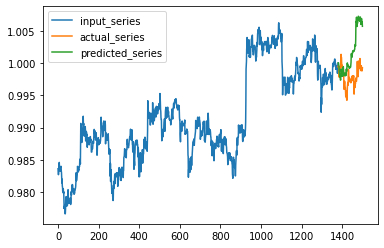

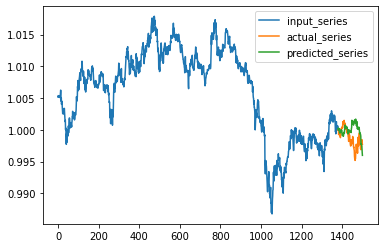

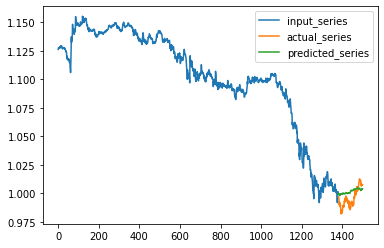

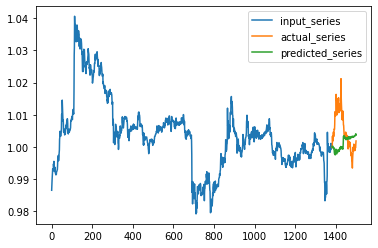

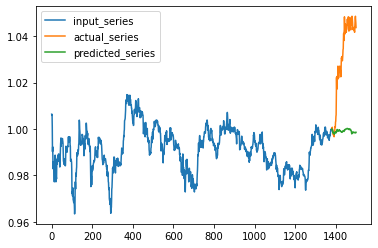

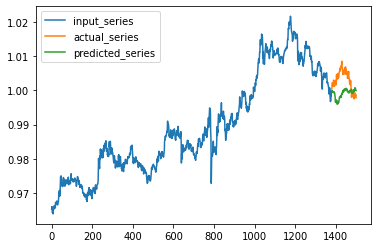

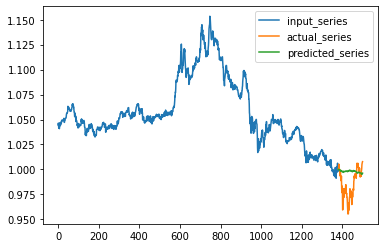

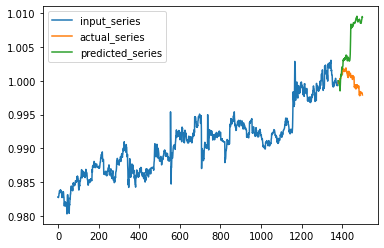

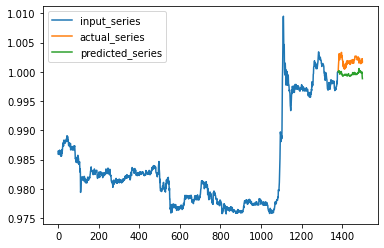

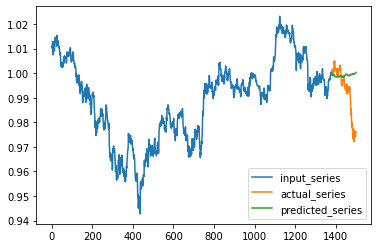

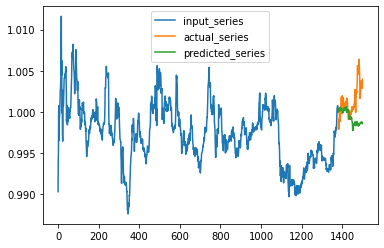

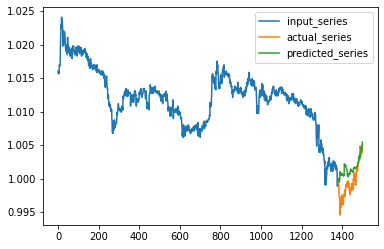

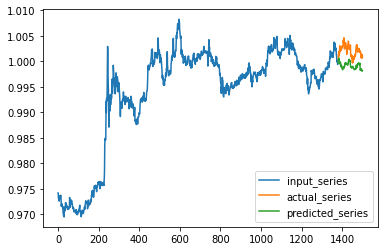

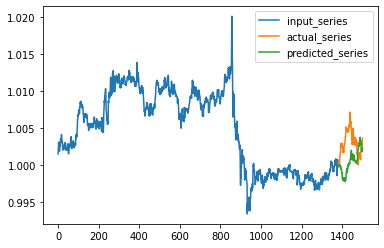

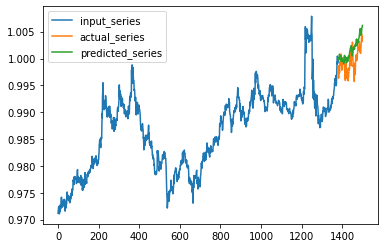

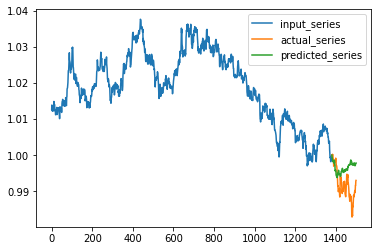

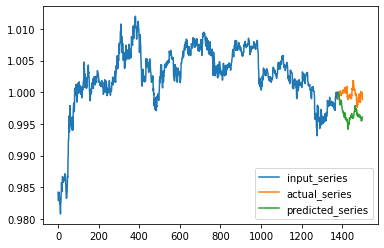

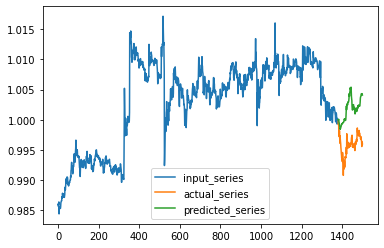

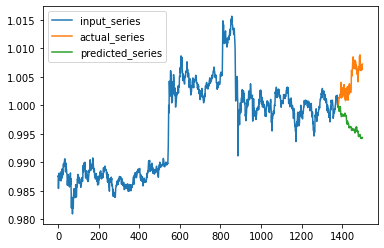

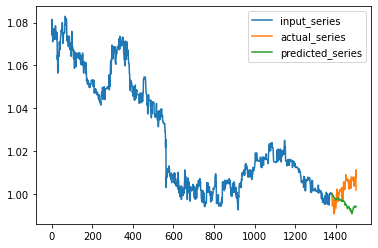

In [29]:
y_train_open = y_train[:,:,1]

for i in range(20): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()
